In [ ]:
import os
import re
import sys
import math
import time
import queue
import shutil
import random
import logging
import operator
import threading
import datetime as dt
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax import nnx
from typing import NamedTuple, TypeAlias, Union, Dict, Callable, Tuple
from pathlib import Path
import jaxlib
import jaxlib.xla_extension
from functools import partial
from dataclasses import dataclass
print(jax.devices())

[CudaDevice(id=0)]


100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]


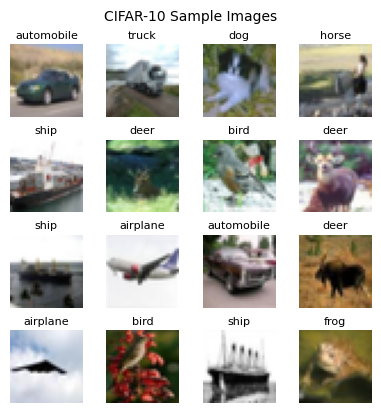

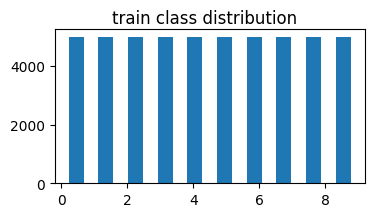

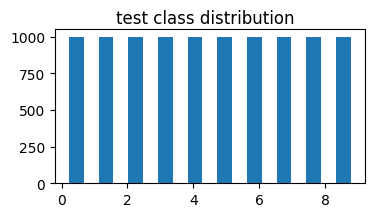

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# --- Data Configuration ---
DATASET_PATH = Path(r"F:\deep_experiments\datasets\CIFAR10_data")
BATCH_SIZE = 512
N_CLASSES = 10

if os.path.exists(DATASET_PATH):
    download_dataset = False
else:
    DATASET_PATH = Path(r"\CIFAR10_data")
    download_dataset = True

# Create the dataset path if it doesn't exist
DATASET_PATH.mkdir(parents=True, exist_ok=True)

# Load CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root=DATASET_PATH, train=True, download=download_dataset, transform=transform)
test_dataset = datasets.CIFAR10(root=DATASET_PATH, train=False, download=download_dataset, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

def display_cifar_samples(num_samples=16, rows=4, cols=4):
    images, labels = next(iter(train_loader))

    # Convert from NCHW to NHWC format and from [-1,1] to [0,1] range
    images = images.numpy()
    images = np.transpose(images, (0, 2, 3, 1))  # NCHW -> NHWC
    images = (images + 1) / 2.0  # [-1,1] -> [0,1]

    cifar_classes = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck']

    fig, axes = plt.subplots(rows, cols, figsize=(4, 4))
    fig.frameon = False
    fig.tight_layout(pad=1.2)

    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(images[i])
            ax.set_title(cifar_classes[labels[i]], y=.96, fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle("CIFAR-10 Sample Images", y=1.02, fontsize=10)
    plt.show()

display_cifar_samples() # Display 16 sample images in a 4x4 grid

get_labels = lambda data_loader: np.array([l for batch in data_loader for l in  batch[1].numpy().tolist()])

train_labels = get_labels(train_loader)
test_labels = get_labels(test_loader)

def plot_hist(x, title:str|None=None):
    plt.figure(figsize=(4, 2), frameon=False)
    plt.hist(x, rwidth=.5)
    if title != None: plt.suptitle(title)
    plt.show()

plot_hist(train_labels, "train class distribution")
plot_hist(test_labels, "test class distribution")

In [3]:
# --- Augmentation Functions ---

Array: TypeAlias = jax.Array #Union[jax.Array, np.ndarray]
PRNGKey: TypeAlias = Union[jaxlib.xla_extension.ArrayImpl, jax.random.PRNGKey] # type: ignore

def identity(images: Array, rng: PRNGKey) -> Array: return images

def random_horizontal_flip(images: Array, rng: PRNGKey) -> Array:
    print("compiling add_normal_noise")
    should_flip = jax.random.bernoulli(rng, 0.5)
    return jax.lax.cond(should_flip, lambda x: jnp.flip(x, axis=3), lambda x: x, images)

def add_normal_noise(images: Array, noise_scale: float = 0.25, rng:PRNGKey=jax.random.key(0)) -> Array:
    """Adds Gaussian noise to images."""
    print("compiling add_normal_noise")
    noise = jax.random.normal(rng, images.shape)
    noise = noise - noise.min()
    noise = noise / noise.max()
    image = (1.0 - noise_scale) * images + noise_scale * noise
    return image

def add_uniform_noise(images: Array, noise_scale: float = 0.05, rng:PRNGKey=jax.random.key(0)) -> Array:
    """Adds uniform noise to images."""
    print("compiling add_uniform_noise")
    return (1.0 - noise_scale) * images + noise_scale * jax.random.uniform(rng, images.shape)

def bernoulli_2Dmask(images: Array, keep_prob: float = 0.8, rng:PRNGKey=jax.random.key(0)) -> Array:
    """Applies a random binary mask to images, setting some pixels to 0."""
    print("compiling bernoulli_2Dmask")
    mask = jax.random.bernoulli(rng, keep_prob, shape=images.shape[-2:])
    return images * mask

def bernoulli_3Dmask(images: Array, keep_prob: float = 0.95, rng:PRNGKey=jax.random.key(0)) -> Array:
    """Applies a random binary mask to images, setting some pixels to 0."""
    print("compiling bernoulli_3Dmask")
    mask = jax.random.bernoulli(rng, keep_prob, shape=images.shape)
    return images * mask

def color_channel_flip(images: Array, rng:PRNGKey=jax.random.key(0)) -> Array:
    """Applies a single, random permutation of color channels to a batch of images."""
    print("compiling color_channel_flip")
    # Note: This applies the *same* permutation to all images in the batch.
    permutation = jax.random.permutation(rng, 3)
    return images[:, permutation, :, :]

def random_color_jitter(
    images: Array, rng: PRNGKey, brightness_strength: float = 0.2, contrast_strength: float = 0.2,
) -> Array:
    """Applies random brightness and contrast adjustments."""
    print("compiling random_color_jitter")
    batch_size = images.shape[0]
    rng_bright, rng_contrast = jax.random.split(rng)
    brightness_shifts = jax.random.uniform(
        rng_bright, shape=(batch_size, 1, 1, 1), minval=-brightness_strength, maxval=brightness_strength
    )
    jittered_images = images + brightness_shifts
    means = jnp.mean(jittered_images, axis=(2, 3), keepdims=True)
    contrast_factors = jax.random.uniform(
        rng_contrast, shape=(batch_size, 1, 1, 1), minval=1.0 - contrast_strength, maxval=1.0 + contrast_strength
    )
    jittered_images = means + contrast_factors * (jittered_images - means)
    return jnp.clip(jittered_images, -1.0, 1.0)

def random_cutout(images: Array, rng: PRNGKey, patch_size: int = 8) -> Array:
    """Randomly masks out a square patch in each image."""
    print("compiling random_cutout")
    batch_size, _, h, w = images.shape
    rng_y, rng_x = jax.random.split(rng)
    center_y = jax.random.randint(rng_y, shape=(batch_size,), minval=0, maxval=h)
    center_x = jax.random.randint(rng_x, shape=(batch_size,), minval=0, maxval=w)
    half_patch = patch_size // 2
    y0 = jnp.clip(center_y - half_patch, 0, h)
    y1 = jnp.clip(center_y + half_patch, 0, h)
    x0 = jnp.clip(center_x - half_patch, 0, w)
    x1 = jnp.clip(center_x + half_patch, 0, w)
    def apply_cutout_to_one_image(image, y0, y1, x0, x1):
        yy, xx = jnp.meshgrid(jnp.arange(h), jnp.arange(w), indexing='ij')
        mask = (yy >= y0) & (yy < y1) & (xx >= x0) & (xx < x1)
        return image * (1.0 - jnp.expand_dims(mask, axis=0))
    return jax.vmap(apply_cutout_to_one_image)(images, y0, y1, x0, x1)

Original Images:


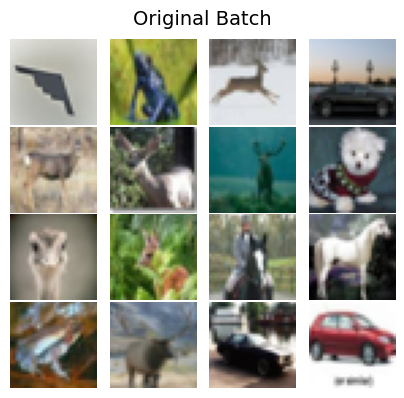


--- JIT Compiling Augmentation Pipeline ---
compiling add_normal_noise
compiling add_normal_noise
compiling add_uniform_noise
compiling bernoulli_2Dmask
compiling bernoulli_3Dmask
compiling color_channel_flip
compiling random_color_jitter
compiling random_cutout
--- Compilation Complete ---

Augmented Images (First Pass):


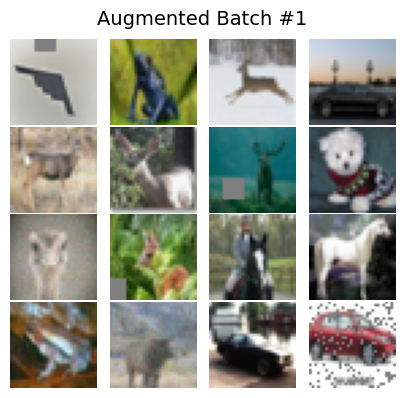

Augmented Images (Second Pass):


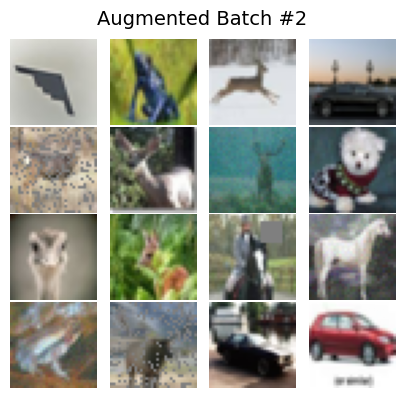

In [ ]:
# --- UPDATED AUGMENTATION PIPELINE ---
# Add the new functions and re-distribute probabilities
AUGMENTATION_PIPELINE: Dict[Callable, float] = {
    identity: 0.20,
    random_horizontal_flip: 0.15, # implicitly adds .75 to identity
    add_normal_noise: 0.15,
    add_uniform_noise: 0.05,
    bernoulli_2Dmask: 0.10,
    bernoulli_3Dmask: 0.03,
    color_channel_flip: 0.02,
    random_color_jitter: 0.15,
    random_cutout: 0.15,
}

# Normalize probabilities to ensure they sum to 1
total_prob = sum(AUGMENTATION_PIPELINE.values())
AUGMENTATION_PIPELINE = {k: v / total_prob for k, v in AUGMENTATION_PIPELINE.items()}

AUGMENTATION_FNS = tuple(AUGMENTATION_PIPELINE.keys())
AUGMENTATION_PROBS = tuple(AUGMENTATION_PIPELINE.values())
assert math.isclose(sum(AUGMENTATION_PROBS), 1.0) # not really needed with the above fix

def apply_random_augmentation_to_one_image(
    image: Array, rng: PRNGKey, aug_fns: Tuple[Callable, ...], probs: jnp.ndarray
) -> Array:
    choice_rng, fn_rng = jax.random.split(rng)
    aug_index = jax.random.choice(choice_rng, a=len(aug_fns), p=probs)
    def create_wrapped_fn(func):
        def wrapped_fn(img, key):
            img_batched = jnp.expand_dims(img, axis=0)
            augmented_batched = func(img_batched, rng=key)
            return jnp.squeeze(augmented_batched, axis=0)
        return wrapped_fn
    wrapped_fns = [create_wrapped_fn(f) for f in aug_fns]
    return jax.lax.switch(aug_index, wrapped_fns, image, fn_rng)

@partial(jax.jit, static_argnames=('aug_fns',))
def augment_image_batch_vmap(
    images: Array, rng: PRNGKey, aug_fns: Tuple[Callable, ...], probs: Tuple[float, ...]
) -> Array:
    rngs_per_image = jax.random.split(rng, num=images.shape[0])
    jnp_probs = jnp.array(probs)
    vmapped_augment = jax.vmap(
        apply_random_augmentation_to_one_image, in_axes=(0, 0, None, None)
    )
    return vmapped_augment(images, rngs_per_image, aug_fns, jnp_probs)

# --- Display Utility ---
def display_cifar_images(images, num_samples=16, rows=4, cols=4, title:str="Images"):
    images_np = np.array(images)
    images_np = np.transpose(images_np, (0, 2, 3, 1))
    images_np = np.clip((images_np + 1) / 2.0, 0, 1)

    fig, axes = plt.subplots(rows, cols, figsize=(4, 4))
    fig.frameon = False
    fig.suptitle(title, y=0.95, fontsize=14)
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(images_np[i])
        ax.axis('off')
    plt.tight_layout(pad=.1, rect=[0, 0, 1, 0.93])
    plt.show()

# --- Main Execution ---
if __name__ == '__main__':
    # 1. Create a key and some dummy data
    key = jax.random.PRNGKey(42)
    # # Create a batch of 16 dummy 32x32 RGB images (range [-1, 1])
    # # Let's make them a bit more interesting than pure noise
    # x = jnp.linspace(-1, 1, 32)
    # grid = jnp.sqrt(x**2 + x[:, None]**2)
    # base_image = jnp.stack([jnp.sin(grid*3), jnp.cos(grid*3), grid - 1], axis=0)
    # images = jnp.repeat(jnp.expand_dims(base_image, 0), 16, axis=0)
    images = jnp.array(next(iter(train_loader))[0].numpy())
    print("Original Images:")
    display_cifar_images(images, title="Original Batch")

    # 2. JIT and run the augmentation
    print("\n--- JIT Compiling Augmentation Pipeline ---")
    key, aug_key = jax.random.split(key)
    # The 'compiling...' messages will print on this first run
    augmented_images = augment_image_batch_vmap(
        images, aug_key, AUGMENTATION_FNS, AUGMENTATION_PROBS
    )
    augmented_images.block_until_ready() # Wait for compilation and execution
    print("--- Compilation Complete ---\n")

    # 3. Run again (should be fast, no re-compilation)
    key, aug_key = jax.random.split(key)
    augmented_images_2 = augment_image_batch_vmap(
        images, aug_key, AUGMENTATION_FNS, AUGMENTATION_PROBS
    ).block_until_ready()

    print("Augmented Images (First Pass):")
    display_cifar_images(augmented_images, title="Augmented Batch #1")

    print("Augmented Images (Second Pass):")
    display_cifar_images(augmented_images_2, title="Augmented Batch #2")

In [ ]:
class Attention(nnx.Module):
    """Standard Multi-Head Attention using Flax's efficient `dot_product_attention` implementation."""
    def __init__(self, dim: int, num_heads: int, qkv_bias: bool = False, rngs: nnx.Rngs = nnx.Rngs(0)):
        super().__init__()
        assert dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.num_heads = num_heads
        self.head_dim = dim // num_heads

        # Fused QKV projection
        self.qkv = nnx.Linear(dim, dim * 3, use_bias=qkv_bias, rngs=rngs)
        # Output projection
        self.proj = nnx.Linear(dim, dim, rngs=rngs)

    def __call__(self, x: Array) -> Array:
        B, N, C = x.shape
        # Project to Q, K, V and reshape for multi-head attention
        # (B, N, 3 * D) -> (B, N, 3, H, D_h) -> (3, B, N, H, D_h)
        qkv = jnp.moveaxis(self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim), 2, 0) # or .transpose(2, 0, 1, 3, 4)
        q_k_v = jnp.split(qkv, 3, 0) # Split along the first dimension
        q, k, v = [tensor.squeeze(0) for tensor in q_k_v]

        attn_output = nnx.dot_product_attention(q, k, v, broadcast_dropout=False)

        # Reshape and project back to original dimension
        # (B, H, N, D_h) -> (B, N, H, D_h) -> (B, N, D)
        out = attn_output.swapaxes(1, 2).reshape(B, N, C)
        out = self.proj(out)
        return out

class SiLU(nnx.Module):
    def __init__(self) -> None:
        super().__init__()

    def __call__(self, x: Array) -> Array:
        return nnx.silu(x)

class FeedForward(nnx.Module):
    """Standard Feed-Forward Network found in Transformers."""
    def __init__(self, dim: int, hidden_dim: int, dropout: float = 0.1, rngs: nnx.Rngs = nnx.Rngs(0)):
        super().__init__()
        self.net = nnx.Sequential(
            nnx.Linear(dim, hidden_dim, rngs=rngs),
            SiLU(),
            nnx.Dropout(dropout, rngs=rngs),
            nnx.Linear(hidden_dim, dim, rngs=rngs),
            nnx.Dropout(dropout, rngs=rngs)
        )
    def __call__(self, x: Array) -> Array:
        return self.net(x)

class GLU(nnx.Module):
    """Gated Linear Unit variant: Sigmoid(W_gate*x) * (W_transform*x)."""
    def __init__(self, in_features: int, hidden_dim: int, out_features: int, dropout: float, bias: bool = False, *, rngs: nnx.Rngs):
        self.fc_gate_value = nnx.Linear(in_features, 2 * hidden_dim, use_bias=bias, rngs=rngs)
        self.fc_out = nnx.Linear(hidden_dim, out_features, use_bias=bias, rngs=rngs)
        self.dropout = nnx.Dropout(rate=dropout, rngs=rngs)

    def __call__(self, x: Array) -> Array:
        gate_val_proj = self.fc_gate_value(x)
        gated_values, gate_input = jnp.split(gate_val_proj, 2, axis=-1)

        gated_activation = nnx.sigmoid(gated_values) * gate_input
        gated_activation = self.dropout(gated_activation)

        out = self.fc_out(gated_activation)
        return out

class TransformerBlock(nnx.Module):
    """A single Transformer Block."""
    def __init__(self, dim: int, num_heads: int, mlp_ratio: float, dropout: float, qkv_bias: bool = False, *, rngs: nnx.Rngs):
        self.norm1 = nnx.LayerNorm(dim, rngs=rngs)
        self.attn = Attention(dim, num_heads, qkv_bias, rngs=rngs)
        self.norm2 = nnx.LayerNorm(dim, rngs=rngs)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.ffn = GLU(in_features=dim, hidden_dim=mlp_hidden_dim, out_features=dim, dropout=dropout, rngs=rngs)

    def __call__(self, x: Array) -> Array:
        # Pre-normalization variant
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x


In [6]:
image_shape: TypeAlias = tuple[int, int, int]

@dataclass
class ViTConfig:
    img_shape: image_shape = (32, 32, 3)
    patch_size: int = 1
    num_classes: int = N_CLASSES
    dim: int = 128
    depth: int = 8
    heads: int = 8
    mlp_ratio: float = 4.0
    channels: int = 3
    dropout: float = 0.1
    rngs: nnx.Rngs = nnx.Rngs(0)


class ConvPatchify(nnx.Module):
    def __init__(self, channels:int, out_dim:int, rngs: nnx.Rngs = nnx.Rngs(0)) -> None:
        super().__init__()
        self.conv1 = nnx.Conv(channels, 32, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.pool1 = lambda x: nnx.max_pool(x, window_shape=(2, 2), strides=(1, 1), padding=((1, 1), (1, 1))) # type: ignore
        self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.pool2 = lambda x: nnx.max_pool(x, window_shape=(2, 2), strides=(1, 1), padding=((1, 1), (1, 1))) # type: ignore
        self.conv3 = nnx.Conv(64, 32, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.pool3 = lambda x: nnx.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        self.conv4 = nnx.Conv(32, out_dim, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.pool4 = lambda x: nnx.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        self.relu = nnx.relu

    def __call__(self, x: Array) -> Array:
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.pool4(x)
        return x


class ViT(nnx.Module):
    """
    Vision Transformer with a CNN-based patchifier (Hybrid ViT: ConViT).
    """
    def __init__(self, config: ViTConfig):
        super().__init__()
        rngs = config.rngs
        dim = config.dim

        # 1. CNN Feature Extractor (Patchifier)
        self.conv_patchifier = ConvPatchify(config.channels, config.dim, rngs=rngs)
        img_size = np.array(config.img_shape[:-1]).prod()
        feature_map_size = img_size // 4**2 # two maxpools with stride 2
        assert feature_map_size == 8**2, f"Feature map size calculation is wrong. Expected 8 instead got {feature_map_size}"

        num_patches = (feature_map_size // config.patch_size)

        # This is an alternative, more direct way to patchify, but we use the CNN above
        # self.patch_embedding = nnx.conv(3, dim, kernel_size=patch_size, strides=patch_size)

        # 2. Transformer specific parameters
        self.pos_embedding = nnx.Param(jax.random.normal(rngs(), (1, num_patches + 1, dim))*.01)
        self.cls_token = nnx.Param(jax.random.normal(rngs(), (1, 1, dim))*.01)
        self.dropout = nnx.Dropout(config.dropout, rngs=rngs)

        # 3. Stack of Transformer Blocks
        self.transformer_blocks = [
            TransformerBlock(dim=dim, num_heads=config.heads, mlp_ratio=config.mlp_ratio, dropout=config.dropout, rngs=rngs)
            for _ in range(config.depth)
        ]

        # 4. Classifier Head
        self.classifier_head = nnx.Sequential(
            nnx.LayerNorm(dim, rngs=rngs),
            nnx.Linear(dim, config.num_classes, kernel_init=nnx.initializers.uniform(0.001), rngs=rngs)
        )

    def __call__(self, img: Array) -> Array:
        B = img.shape[0]

        # 1. Create patch embeddings using the CNN
        x = self.conv_patchifier(img) # Shape: (B, H', W', dim) e.g., (B, 8, 8, dim)

        # Flatten for transformer: (B, H' * W', dim)
        x = x.reshape(B, -1, x.shape[-1])
        N = x.shape[1] # Number of patches

        # 2. Prepend CLS token
        cls_tokens = jnp.broadcast_to(self.cls_token.value, (B, 1, x.shape[-1]))
        x = jnp.concatenate((cls_tokens, x), axis=1) # Shape: (B, N + 1, dim)

        # 3. Add positional embedding
        x += self.pos_embedding[:, :(N + 1)]
        x = self.dropout(x)

        # 4. Pass through transformer blocks
        transformer_in = x
        for i, block in enumerate(self.transformer_blocks):
            x = block(x)
            if i % 2 == 0:
                residual = x
            else:
                x += residual
        x += transformer_in
        # 5. Get the CLS token output and classify
        cls_output = x[:, 0]
        return self.classifier_head(cls_output)

In [7]:
config = ViTConfig()
key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(0)
model = ViT(config)

NUM_EPOCHS = 40
num_batches_per_epoch = len(train_loader)
total_steps = NUM_EPOCHS * num_batches_per_epoch
warmup_steps = int(0.1 * NUM_EPOCHS * num_batches_per_epoch)

@dataclass
class LRConfig:
    init_value: float = 3e-4
    peak_value: float = 2e-3
    warmup_steps: int = warmup_steps
    decay_steps: int = total_steps - warmup_steps
    end_value: float = 2e-5
    exponent: float = 1.0

lr_config = LRConfig()
schedule = optax.warmup_cosine_decay_schedule(
    **lr_config.__dict__
)

GRAD_CLIP = 1.0
optimizer = nnx.Optimizer(model, optax.chain(
    optax.clip_by_global_norm(GRAD_CLIP),
    optax.adamw(learning_rate=schedule)
))
p_sizes = jax.tree.map(lambda p: p.size if isinstance(p, jnp.ndarray) else 0, nnx.state(model))
p_count = jax.tree.reduce(operator.add, p_sizes)
expected_untrained_loss = -math.log(1/N_CLASSES)
print(
    f'expected untrained loss: {expected_untrained_loss:.3f}\n'
    f'model parameter count: {p_count:,}\n'
    f'# of batches per epoch: {num_batches_per_epoch}')

def per_layer_grad_norm(grads:nnx.statelib.State) -> dict:
    return jax.tree.map(jnp.linalg.norm, grads.to_pure_dict())

def summery_norm(parameter_dict:dict) -> tuple[Array, Array]:
    arr = jnp.array(jax.tree.flatten(parameter_dict)[0])
    return arr.mean(), arr.std()

class History(NamedTuple):
    loss: list = []
    accuracy: list = []
    LR: list = []
    gradient_norm: list = []

    def __call__(self, loss: float, accuracy: float, lr: float, grad_norms: dict) -> str:
        self.loss.append(loss)
        self.accuracy.append(accuracy)
        self.LR.append(lr)
        self.gradient_norm.append(grad_norms)
        grad_norm_mean, grad_norm_std = summery_norm(grad_norms)
        list_to_fit = [
            f"Loss: {loss:.4f}",
            f"Acc: {accuracy:.4f}",
            f"LR: {lr:.6f}",
            f"grad norm mean: {grad_norm_mean:.3f}",
            f"grad norm std: {grad_norm_std:.3f}"]
        return " | ".join(list_to_fit)

history = History()

log_name = f"ViT_train_info_{dt.datetime.now().date().isoformat()}"
logger = logging.getLogger(log_name)
logging.basicConfig(filename=f'{log_name}.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', encoding='utf-8')


expected untrained loss: 2.303
model parameter count: 2,187,116
# of batches per epoch: 98


In [8]:
# --- Training Setup ---
def compute_loss(logits: Array, targets: Array) -> Array:
    loss_terms = optax.softmax_cross_entropy_with_integer_labels(
        logits, targets
    )
    return loss_terms.mean()

@nnx.jit
def train_step(
    model: nnx.Module,
    optimizer: nnx.Optimizer,
    inputs: jax.Array, targets: jax.Array
    ) -> Union[Array, tuple]:
    model.train()
    def loss_fn(model):
        logits = model(inputs)
        acc = jit_accuracy(logits, targets)
        return compute_loss(logits, targets), acc
    (loss, acc), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model)
    optimizer.update(grads)
    return loss, acc, grads

def accuracy(logits: Array, targets: Array, return_pred_class:bool=False) -> Union[tuple[Array, Array], float, Array]:
    logits_argmax = logits.argmax(-1)
    mean_accuracy = (logits_argmax == targets).mean()
    out = (mean_accuracy, logits_argmax) if return_pred_class else mean_accuracy
    return out
jit_accuracy = jax.jit(lambda logits, targets: accuracy(logits, targets, False))

In [9]:
c = 0
for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    for idx, (images, labels) in enumerate(train_loader):
        key, subkey = jax.random.split(key)
        inputs, targets = jnp.array(images.numpy()), jnp.array(labels.numpy())
        inputs: Array = augment_image_batch_vmap(
            inputs, subkey, AUGMENTATION_FNS, AUGMENTATION_PROBS
        )
        loss, acc, grads = train_step(model, optimizer, inputs.swapaxes(1, -1), targets)
        lr = schedule(c).item(); c += 1 # type: ignore
        history_report = history(loss, acc, lr, per_layer_grad_norm(grads))

        if idx % 10 == 0:
            reports = [
                f"\rEpoch: {round(epoch + (idx/num_batches_per_epoch), 2):.2f}/{NUM_EPOCHS}",
                history_report
                ]
            logger.info(" -- ".join(reports))

        if idx % 20 == 0:
            print(*reports, sep=' | ', end='', flush=True)

    Epoch_Report = [
        f"\r>>> Epoch {round(epoch + (idx/num_batches_per_epoch))} complete.",
        f"Epoch lasted {round(time.time() - epoch_start_time)} seconds <<<\n"]
    logger.info(" -- ".join(Epoch_Report))


Epoch: 0.82/40 | Loss: 1.9033 | Acc: 0.3496 | LR: 0.000647 | grad norm mean: 0.355 | grad norm std: 0.956compiling add_normal_noise
compiling add_normal_noise
compiling add_uniform_noise
compiling bernoulli_2Dmask
compiling bernoulli_3Dmask
compiling color_channel_flip
compiling random_color_jitter
compiling random_cutout
Epoch: 39.82/40 | Loss: 0.2204 | Acc: 0.9297 | LR: 0.000020 | grad norm mean: 0.102 | grad norm std: 0.208

In [13]:
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss, total_acc, total_count = 0, 0, 0
    for batch in test_loader:
        inputs, targets = batch
        inputs, targets = jnp.array(inputs.numpy()), jnp.array(targets.numpy())
        logits = model(inputs.swapaxes(1, -1))
        loss = criterion(logits, targets)
        acc = jit_accuracy(logits, targets)

        total_loss += loss.item() * len(inputs)
        total_acc += acc * len(inputs)
        total_count += len(inputs)

    avg_loss = total_loss / total_count
    avg_acc = total_acc / total_count
    return {"avg_loss": avg_loss, "avg_accuracy": avg_acc}

eval_results =  evaluate(model, test_loader, compute_loss)
print(*[f'{k.replace("_", " ").capitalize()}: {v}' for k, v in eval_results.items()], sep='  ')

Avg loss: 0.6373643837928772  Avg accuracy: 0.8159000277519226


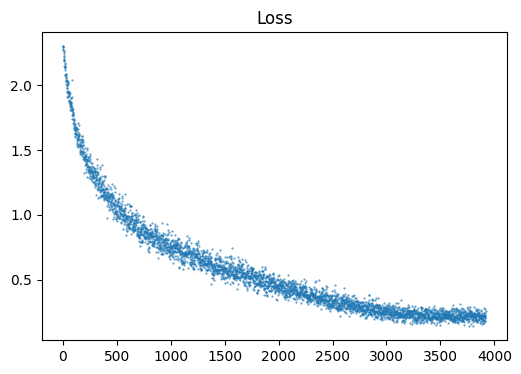

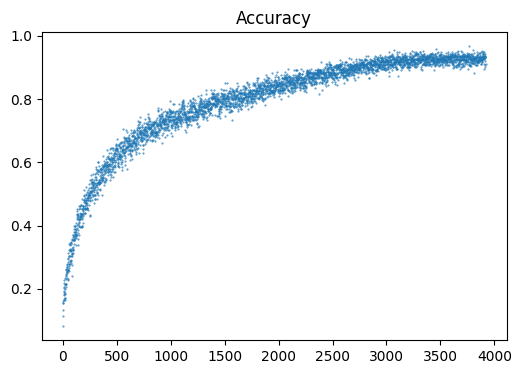

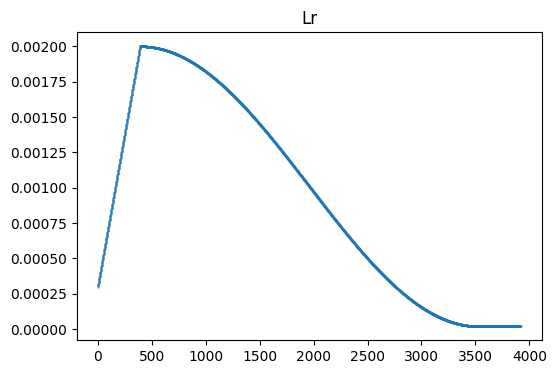

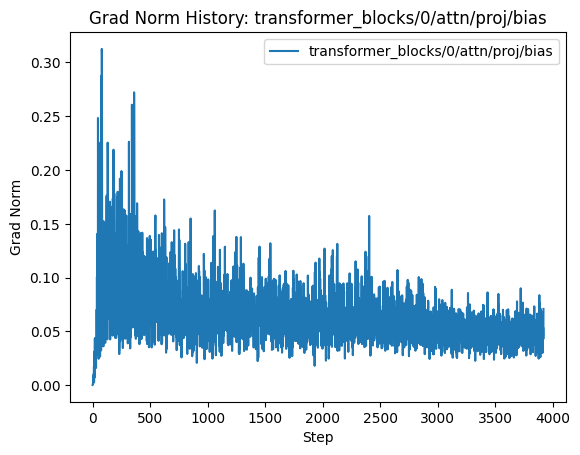

In [ ]:
def plot(k:str):
    plt.figure(figsize=(6, 4), frameon=False)
    plt.plot(history.__getattribute__(k), '.', alpha=.8, ms=1)
    plt.title(k.replace('_', ' ').capitalize())
    plt.show()

for k in history.__annotations__:
    if k != 'gradient_norm':
        plot(k)

def stack_grad_norm_history(grad_norm_history):
    """
    Given a list of nested dicts (each a grad norm snapshot),
    return a nested dict with the same structure, but with lists/arrays
    of values for each leaf, representing the history over time.
    """
    from collections.abc import Mapping
    import numpy as np

    def recursive_stack(keys, snapshots):
        # Base case: if not a dict, stack values
        if not isinstance(snapshots[0], Mapping):
            # Stack or collect as list
            try:
                return np.stack(snapshots)
            except Exception:
                return list(snapshots)
        # Otherwise, recurse for each key
        out = {}
        for k in snapshots[0]:
            out[k] = recursive_stack(keys + [k], [snap[k] for snap in snapshots])
        return out

    return recursive_stack([], grad_norm_history)

clean_dict = stack_grad_norm_history(history.gradient_norm)
rows = round(len(clean_dict)**.5)
dm = divmod(len(clean_dict), rows)
cols = dm[0]+1 if dm[1] != 0 else dm[0]

stacked = clean_dict

# To plot a specific component, e.g. transformer_blocks[0]['attn']['proj']['bias']:
def plot_grad_norm(stacked, key_path, label=None):
    d = stacked
    for k in key_path:
        d = d[k]
    plt.plot(d, label=label or '/'.join(map(str, key_path)))
    plt.xlabel("Step")
    plt.ylabel("Grad Norm")
    plt.title("Grad Norm History: " + '/'.join(map(str, key_path)))
    plt.legend()
    plt.show()

# plot transformer_blocks[0]['attn']['proj']['bias']
plot_grad_norm(
    stacked,
    ['transformer_blocks', 0, 'attn', 'proj', 'bias']
)

In [14]:
nnx.display(model)